# ITSM 601 Semester Project
## Austin Animal Shelter Data
### Predicts Adopted/Not Adopted

Travis Lemon and John Bonfardeci
2018-04-08

#### What this notebook does:
* Create randomized K cross-validation (CV) groups
* For-each CV:
    * Split randomized data into (k-1)/k training data and 1/k testing
    * Run LDA K times
        * Find best cutoff (Youden's Index and Distance-to-corner) and test cutoff set
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
    * Run Logistic Regression K times
        * Find best cutoff (Youden's Index and Distance-to-corner) and test cutoff set
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
Directions in Jupyter Notebook: Select `Cell -> Run All`. 
Look for printed output and ROC plots at bottom of notebook.

In [40]:
# Change These Parameters           

# relative file path; can place in same working directory as notebook
file_path = 'animal_shelter_train.csv'

# the column names of the continuous predictors
feature_names = ['Cat', 'IntactFemale', 'IntactMale', 'NeuteredMale', 'SpayedFemale', 'AgeRange_0', 
                 'AgeRange_1_4', 'AgeRange_10_15', 'AgeRange_15_20', 'AgeRange_5_9', 'Black_Brown', 
                 'Black_Tan', 'Black_White', 'Blue', 'Blue Tabby', 'Blue_White', 'Brown', 'Brown_White', 
                 'Calico', 'OrangeTabby', 'Other', 'Red', 'Tan', 'Tortie', 'Tricolor', 'Yellow', 'MixBreed', 'PitBull']

# name of target column
target_name = 'Adopted'

# what value represents the positive value in a binary response: e.g. 1, 'Y', 'T', ...
target_value = 1 

# LDA Solver to use. 
#    Options: 
#        'lsqr' (Least squares solution) - can use with shrikage
#        'svd' (Singular value decomposition) - use with large num features
#        'eigen' (Eigenvalue decomposition) - can use with shrikage
# http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
lda_solver = 'lsqr'

# change to None to run LDA without shrinkage
# Options: None, 'auto', float between 0 and 1
# see http://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py
lda_shrinkgage = 'auto'

# number of cross-validation groups to run
num_cv = 5

output_data_to_excel = False


In [41]:
# Imports

import math
import pandas as pd
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from copy import copy

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import VarianceThreshold

In [42]:
# load the data into Pandas Dataframe object
usecols = copy(feature_names).append(target_name)

df = pd.read_csv(file_path, usecols=usecols) # returns new Pandas DataFrame 

# randomize rows (http://quabr.com/29576430/shuffle-dataframe-rows)
#df = _df.iloc[np.random.permutation(len(df))]

# create new series with target value converted to 1/0 for the binary responses
y = pd.Series( map(lambda x: 1 if x == target_value else 0, df[target_name]) ).as_matrix() # <class 'pandas.core.series.Series'>

# get our predictor variables as a multidimensional array (matrix)
X = df[feature_names].as_matrix() # <class 'pandas.core.frame.DataFrame'>

# check the X and y data
print(y[0:5])
print(X[0:5])

# good to go...

[1 1 1 0 1]
[[1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


In [116]:
# Confusion Matrix
def get_confusion_matrix(actual, predicted):
    """
    For example: 
    
       n=165   | Predicted NO | Predicted YES
    ------------------------------------------
    Actual NO  |       50     |      10       |
    ------------------------------------------
    Actual YES |       5      |      100      |
    ------------------------------------------
    
    The diagonal elements represent the number of points for which the predicted label is equal to the true label,
    while off-diagonal elements are those that are mislabeled by the classifier.
    The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.
    """
    cm = confusion_matrix(actual, predicted)

    """
    Structure of cm:
    [[2530  662]
    [ 637 1517]]
    """
    tn = cm[0][0]; fp = cm[0][1]; fn = cm[1][0]; tp = cm[1][1];
    tpr = tp / (tp + fn)
    fpr = tn / (tn + fp)
    precision = tp / (tp + fp) 
    
    print('TPR', tpr, ': FPR:', fpr, ': Precision:', precision)
    return cm

In [80]:
def show_roc(kfolds, mean_tpr, mean_fpr, title, lw=2):
    
    colors = cycle(['cyan', 'red', 'seagreen', 'darkorange', 'blue'])
    
    # Plot the ROC Curve for this CV group
    i=0
    for (k, color) in zip(kfolds, colors):
        tpr, fpr = k[0], k[1]
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
        i += 1
    
    # Plot the ROC Curve for logistic regression
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')

    mean_tpr /= len(kfolds)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive (1-Specificity)')
    plt.ylabel('True Positive (Sensitivity)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

C:\Users\bonfardeci-j\Anaconda2\envs\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


TPR 0.7042711234911792 : FPR: 0.7926065162907269 : Precision: 0.6961909132629647
[[2530  662]
 [ 637 1517]]
TPR 0.6935933147632312 : FPR: 0.8035714285714286 : Precision: 0.7043847241867044
[[2565  627]
 [ 660 1494]]
TPR 0.6662024141132776 : FPR: 0.8135964912280702 : Precision: 0.7068965517241379
[[2597  595]
 [ 719 1435]]
TPR 0.6973073351903436 : FPR: 0.793233082706767 : Precision: 0.6947271045328399
[[2532  660]
 [ 652 1502]]
TPR 0.6897352531351603 : FPR: 0.8026315789473685 : Precision: 0.7021276595744681
[[2562  630]
 [ 668 1485]]


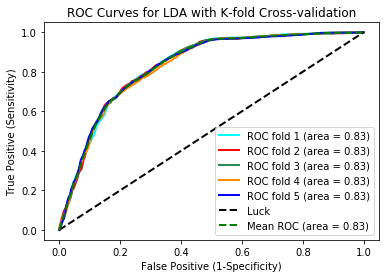

In [117]:
# Run LDA with cross-validation and plot ROC curves
def run_lda():
    rand = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=rand)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
    kfolds = []
    i = 0

    # For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
    # TODO - add feature selection per CV
    # train, test are of type <type 'numpy.ndarray'>
    for (train, test) in cv.split(X, y):

        # train LDA on training dataset
        lda = LinearDiscriminantAnalysis(solver=lda_solver, shrinkage=lda_shrinkgage).fit(X[train], y[train])

        # test LDA on test dataset
        prob = lda.predict_proba(X[test]) # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)

        # gives you the predicted label for each sample
        # default threshold/cutoff is 0.5?
        train_predicted = lda.predict(X[train])
        predicted = lda.predict(X[test]) 

        # Compute ROC curve and area under the curve
        # fpr = false positive rate (1-specificity)
        # tpr = true positive rate (sensitivity)
        fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1]) # returns <type 'numpy.ndarray'> x 3
        
        # add mean Sensitivity (TPR)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
        cm = get_confusion_matrix(actual=y[test].tolist(), predicted=predicted.tolist())
        print(cm)

        # get Area Under Curve
        roc_auc = auc(fpr, tpr)
        
        kfolds.append([tpr, fpr])
        i += 1
    #/for (train, test)...
    
    show_roc(kfolds, mean_tpr, mean_fpr, 'ROC Curves for LDA with K-fold Cross-validation')
    
run_lda()

TPR 0.6778087279480037 : FPR: 0.8145363408521303 : Precision: 0.7115009746588694
[[2600  592]
 [ 694 1460]]
TPR 0.6889507892293407 : FPR: 0.7982456140350878 : Precision: 0.6973684210526315
[[2548  644]
 [ 670 1484]]
TPR 0.6722376973073352 : FPR: 0.806704260651629 : Precision: 0.7012106537530266
[[2575  617]
 [ 706 1448]]
TPR 0.6624883936861653 : FPR: 0.8117167919799498 : Precision: 0.7036489151873767
[[2591  601]
 [ 727 1427]]
TPR 0.6483975847654435 : FPR: 0.8342731829573935 : Precision: 0.7251948051948052
[[2663  529]
 [ 757 1396]]


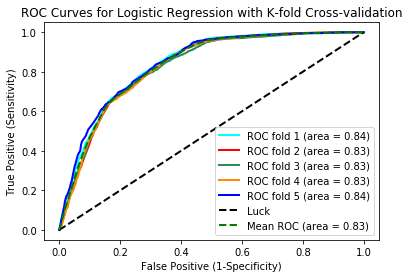

In [118]:
# Run logistic Regression with cross-validation and plot ROC curves
def run_logit():
    i=0
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
    mean_accuracy = 0
    kfolds = []
    mean_accuracy = 0

    for (train, test) in cv.split(X, y):

        logreg = LogisticRegression(C=1e5)
        logreg.fit(X[train], y[train])
        prob = logreg.predict_proba(X[test])
        train_predicted = logreg.predict(X[train])
        predicted = logreg.predict(X[test]) # 1/0

        # Compute ROC curve and area the curve
        # fpr = false positive rate (1-specificity)
        # tpr = true positive rate (sensitivity)
        fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1]) # returns <type 'numpy.ndarray'> x 3

        # add mean Sensitivity
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
        cm = get_confusion_matrix(actual=y[test].tolist(), predicted=predicted.tolist())
        print(cm)

        # get Area Under Curve
        roc_auc = auc(fpr, tpr)

        kfolds.append([tpr, fpr])
        i += 1
    #/for (train, test)...

    show_roc(kfolds, mean_tpr, mean_fpr, 'ROC Curves for Logistic Regression with K-fold Cross-validation')
    
run_logit()